In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk('./global-wheat-detection/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./global-wheat-detection/input/train.csv
./global-wheat-detection/input/sample_submission.csv
./global-wheat-detection/input/train/026b6f389.jpg
./global-wheat-detection/input/train/cc2bbb768.jpg
./global-wheat-detection/input/train/72bb74284.jpg
./global-wheat-detection/input/train/3940de6a5.jpg
./global-wheat-detection/input/train/c00e6b4c5.jpg
./global-wheat-detection/input/train/f0b1b4fa3.jpg
./global-wheat-detection/input/train/6939a6e17.jpg
./global-wheat-detection/input/train/b88fcdafb.jpg
./global-wheat-detection/input/train/ab1bb325c.jpg
./global-wheat-detection/input/train/e6cffbb3d.jpg
./global-wheat-detection/input/train/aa82bfd6a.jpg
./global-wheat-detection/input/train/e9f7ec6f1.jpg
./global-wheat-detection/input/train/1b99d2fd6.jpg
./global-wheat-detection/input/train/63467d323.jpg
./global-wheat-detection/input/train/9b58d4c4e.jpg
./global-wheat-detection/input/train/e0a241bd5.jpg
./global-wheat-detection/input/train/68561559e.jpg
./global-wheat-detection/input/train/1e

In [2]:
import cv2
import os
import re

# Imports for image transforms
# Albumentations bounding box augmentation docs: https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Torch imports
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [3]:
# Install Ax for Bayesian Optimization of hyperparameters
# !pip install ax-platform

In [4]:
# Ax imports
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
# from ax.utils.tutorials.cnn_utils import train, evaluate

init_notebook_plotting()

[INFO 11-22 05:36:44] ipy_plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32

In [50]:
# INPUT_DIR = '/kaggle/input/global-wheat-detection/'
# OUTPUT_DIR = '/kaggle/output/'
# TRAIN_DIR = f'{INPUT_DIR}/train'
# TEST_DIR = f'{INPUT_DIR}/test'
INPUT_DIR = './global-wheat-detection/input'
OUTPUT_DIR = './global-wheat-detection/output'
TRAIN_DIR = f'{INPUT_DIR}/train'
TEST_DIR = f'{INPUT_DIR}/test'

In [51]:
train_df = pd.read_csv(f'{INPUT_DIR}/train.csv')
train_df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [52]:
train_df.shape

(147793, 5)

In [53]:
# Create individual columns for data from train_df['bbox']
bbox_cols = ['x', 'y', 'w', 'h']
for c in bbox_cols:
    train_df[c] = -1

In [54]:
train_df.head()

image_id  width  height                         bbox   source  x  y  w  h
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1 -1 -1 -1 -1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1 -1 -1 -1 -1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1 -1 -1 -1 -1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1 -1 -1 -1 -1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1 -1 -1 -1 -1

In [55]:
train_df['bbox'][1]

'[226.0, 548.0, 130.0, 58.0]'

In [56]:
"""
Reformats bbox entry for insertion into newly created x, y, w, h rows
Input: box (String) in form "[x, y, w, h]"
Output: data (list) in form [x, y, w, h]
"""
def extract_bbox_data(box):
    # NOTE: not sure if this properly accounts for image with no bbox
    data = [x.strip() for x in box.strip("[]").split(",")]
    if len(data) == 0:
        data = [-1, -1, -1, -1]
    return data

# Get string data from bbox into numerical data in bbox_cols
train_df[bbox_cols] = np.stack(train_df['bbox'].apply(lambda x: extract_bbox_data(x)))

In [57]:
train_df.head()

image_id  width  height                         bbox   source      x  \
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1  834.0   
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1  226.0   
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1  377.0   
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1  834.0   
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1   26.0   

       y      w      h  
0  222.0   56.0   36.0  
1  548.0  130.0   58.0  
2  504.0   74.0  160.0  
3   95.0  109.0  107.0  
4  144.0  124.0  117.0

In [58]:
train_df.drop(columns='bbox', inplace=True)

In [59]:
train_df.head()

image_id  width  height   source      x      y      w      h
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0

In [60]:
for c in bbox_cols:
    train_df[c] = train_df[c].astype(np.float)

In [61]:
image_ids = train_df['image_id'].unique()
image_ids.shape

(3373,)

In [62]:
3373 * .2

674.6

In [63]:
# Split train_df into 80% train, 20% validation
train_ids = image_ids[:-675]
valid_ids = image_ids[-675:]

In [64]:
full_df = train_df[train_df['image_id'].isin(image_ids)]
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]
# train_df = train_df[train_df['image_id'].isin(image_ids)]

In [21]:
train_df.shape, valid_df.shape
# train_df.shape

((122577, 8), (25216, 8))

In [22]:
"""
Albumentations transforms for creating datasets from raw data.
These functions call A.compose() which returns a transform function that preforms
image augmentation.
Called by creating a data dictionary and calling transform_fn(**data)
Will be used later in our Dataset object definition
"""

bound_params = {
    'format': 'pascal_voc',
    'label_fields': ['labels']
}

"""
Transforms for training data. Flip image with probability of .5,
convert to torch Tensor with probability of 1.
"""
def train_transform():
    # Parameter p is the probability of performing the transform
    return A.Compose([A.Flip(p=0.5), ToTensorV2(p=1.0)], bbox_params=bound_params)

# This actually ended up making it worse
# def train_transform_improved():
#     return A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.OneOf([A.RandomContrast(),A.RandomGamma(),A.RandomBrightness()], p=1.0),
#     ToTensorV2(p=1.0)], bbox_params=bound_params)

"""
Transforms for validation data. Only convert to torch Tensor (p=1)
"""
def valid_transform():
    return A.Compose([ToTensorV2(p=1.0)], bbox_params=bound_params)

In [23]:
train_df.head()

image_id  width  height   source      x      y      w      h
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0

In [24]:
# Testing dataset workflow for single image before defining Dataset class
t_image_id = 'b6ab77fd7'
t_image = cv2.imread(f'{TRAIN_DIR}/{t_image_id}.jpg', cv2.IMREAD_COLOR)
t_image = cv2.cvtColor(t_image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

In [25]:
t_box_data = train_df[train_df['image_id']==t_image_id]
t_boxes = t_box_data[bbox_cols].values
t_boxes[:,2] = t_boxes[:,0] + t_boxes[:,2]
t_boxes[:,3] = t_boxes[:,1] + t_boxes[:,3]
t_boxes = t_boxes.astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


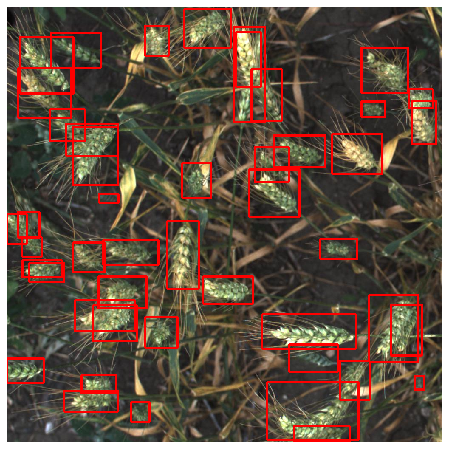

In [26]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
for box in t_boxes:
    cv2.rectangle(t_image, (box[0], box[1]), (box[2], box[3]), (200,0,0), 3)
ax.set_axis_off()
ax.imshow(t_image)

In [27]:
"""
torch Dataset object for our raw data. Dataset subclasses must overwrite the following:
__getitem__(): fetches a data sample for a given key
__len__(): returns he size of the dataset
"""
class WheatDataset(Dataset):
    
    """
    Parameters:
        df: dataframe containing image_id, width, height, source, x, y, w, h
        directory: directory where image corresponding to image_id is stored
        transforms: transform function
    """
    def __init__(self, df, directory, transforms=None):
        super().__init__()
        
        self.image_ids = df['image_id'].unique()
        self.df = df
        self.dir = directory
        self.transforms = transforms
        
    def __len__(self):
        return int(self.image_ids.shape[0])
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image = cv2.imread(f'{self.dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # cv2 reads images into BGR format, must convert to RGB for f-RCNN
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # f-RCNN requires images in [C,W,H] form with values in [0,1]
        image /= 255.0
        
        image_bbox_data = self.df[self.df['image_id'] == image_id]
        bboxes = image_bbox_data[bbox_cols].values
        # f-RCNN requires bboxes in pascal_voc format: [xmin, ymin, xmax, ymax]
        bboxes[:,2] = bboxes[:,0] + bboxes[:,2]
        bboxes[:,3] = bboxes[:,1] + bboxes[:,3]
        
        # we only have 1 class (wheat head) so label tensor is all ones
        labels = torch.ones((image_bbox_data.shape[0],), dtype=torch.int64)
        
        target = {
            'boxes': bboxes,
            'labels': labels,
            'image_id': torch.tensor([index])
        }
        
        if self.transforms:
            dataToTransform = {
                'image': image,
                'bboxes': bboxes,
                'labels': labels
            }
            transData = self.transforms(**dataToTransform)
            image = transData['image']
            target['boxes'] = torch.tensor([list(tup) for tup in transData['bboxes']], dtype=torch.float32)
        
        return image, target, image_id
            

In [28]:
"""
Model creation. Using frcnn with resnet50 backbone that has been pretrained on
COCO dataset
"""

# get pretrained data from internet once then save to file for quicker use
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# torch.save(model, 'frcnn_pretrained.pth')
# model = torch.load('frcnn_pretrained.pth')

In [29]:
num_classes = 2 # wheat head + background (background required for fRCNN)
input_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace pretrained head with new, untrained fRCNN predictor
model.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes)

In [30]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

# Model Training

Training process:
* Create train and valid WheatDatasets
* Create DataLoaders from Datasets
* Get training parameters as params in model.parameters() that require gradient
* Set up SGD optimizer w/ lr=5e-3, momentum=.9, decay=5e-4
* Set num epochs
* Do numEpochs iterations of standard PyTorch training loop
* Infer bboxes on validation data and show sample as before 
* Save model to disk

Standard PyTorch training loop. For image, targets, image_ids in training dataloader:
1. Zero the parameter gradients
2. Call the model to get loss
3. Backprop loss
4. Step opimizer forward

In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))

model.to(device)

train_dataset = WheatDataset(train_df, TRAIN_DIR, train_transform())
valid_dataset = WheatDataset(valid_df, TRAIN_DIR, valid_transform())
# train_dataset = WheatDataset(train_df, TRAIN_DIR, train_transform_improved())

train_dl = DataLoader(dataset=train_dataset, batch_size=16, num_workers=4, collate_fn=collate_fn)
valid_dl = DataLoader(dataset=valid_dataset, batch_size=1, collate_fn=collate_fn)

train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.SGD(train_params, lr=5e-3, momentum=.9, weight_decay=5e-4)

## Vanilla Pytorch Training Loop:

In [32]:
# from IPython.display import display, clear_output # for outputting loss on same line
# model.train()
# epochs = 30
# overall_epoch_losses = []
# for epoch in range(epochs):
#     epoch_losses = []
#     for imgs, targets, img_ids in train_dl:
#         imgs = list(image.to(device) for image in imgs)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# #         clear_output(wait=True)
#         optimizer.zero_grad()
#         loss_out = model(imgs, targets)
#         loss_total = sum([loss for loss in loss_out.values()])
#         loss_total.backward()
#         epoch_losses.append(loss_total.item())
# #         display(f'Batch Loss: {loss_total.item()}, epoch {epoch + 1} avg loss: {sum(epoch_losses)/len(epoch_losses)}')
#         print(f'Batch Loss: {loss_total.item()}, Epoch {epoch + 1} avg loss: {sum(epoch_losses)/len(epoch_losses)}')
#         optimizer.step()
#     overall_epoch_losses.append(sum(epoch_losses)/len(epoch_losses))
#     print(f'Epoch {epoch + 1} loss: {overall_epoch_losses[-1]}')
# print(f'Total loss: {sum(overall_epoch_losses)/len(overall_epoch_losses)}')

## Ax Training Loop With Hyperparameter Optimization:

In [33]:
from typing import Dict, List, Optional, Tuple
from torch import nn
import copy

def train(
    net: nn.Module,
    train_loader: DataLoader,
    parameters: Dict[str, float],
    dtype: torch.dtype,
    device: torch.device,
) -> nn.Module:
    """
    Train CNN on provided data set.

    Args:
        net: initialized neural network
        train_loader: DataLoader containing training set
        parameters: dictionary containing parameters to be passed to the optimizer.
            - lr: default (0.001)
            - momentum: default (0.0)
            - weight_decay: default (0.0)
            - num_epochs: default (1)
        dtype: torch dtype
        device: torch device
    Returns:
        nn.Module: trained CNN.
    """
    print(f'Training on {parameters}')
    
    # Initialize network
    net.to(device=device)  # pyre-ignore [28]
    net.train()
    # Define loss and optimizer
#     criterion = nn.NLLLoss(reduction="sum")
    optimizer = torch.optim.SGD(
        [p for p in net.parameters() if p.requires_grad],
        lr=parameters.get("lr"),
        momentum=parameters.get("momentum"),
        weight_decay=parameters.get("weight_decay"),
    )
    
    num_epochs = parameters.get("num_epochs")

    # Train Network
    # pyre-fixme[6]: Expected `int` for 1st param but got `float`.
    for _ in range(num_epochs):
        for imgs, targets, img_ids in train_loader:
            # move data to proper dtype and device
            imgs = list(image.to(device) for image in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(imgs, targets)
            loss = sum(l for l in outputs.values())
            loss.backward()
            optimizer.step()
            
    return net


def calc_iou(trueBox, predBox):
    t_xmin, t_ymin, t_xmax, t_ymax = trueBox
    p_xmin, p_ymin, p_xmax, p_ymax = predBox
    
    overlap_area = 0.0
    union_area = 0.0
    
    xdiff = min(t_xmax, p_xmax) - min(t_xmin, p_xmin)
    ydiff = min(t_ymax, p_ymax) - min(t_ymin, p_ymin)
    
    t_area = (t_xmax - t_xmin) * (t_ymax - t_ymin)
    p_area = (p_xmax - p_xmin) * (p_ymax - p_ymin)
    
    if (ydiff > 0) and (xdiff > 0): overlap_area = xdiff * ydiff
    
    union_area = (t_area + p_area - overlap_area)
    
    return overlap_area / union_area
    
    
def find_best(trues, predicted_box, threshold=0.5):
    best_iou = -np.inf
    best_idx = -1
    
    for idx, true_box in enumerate(trues):
        curr_iou = calc_iou(true_box, predicted_box)
        
        if (curr_iou > threshold) and (curr_iou > best_iou):
            best_iou = curr_iou
            best_idx = idx
            
    return best_idx
    
def calc_boxes_precision(sorted_preds, true_targets, threshold=0.5):
    tp = 0 # true positives
    fp = 0 # false positives
    fn = 0 # false negatives
    
    false_negatives = []
    for idx, pred in enumerate(sorted_preds):
        t_idx_best = find_best(true_targets, pred, threshold=threshold)
        if t_idx_best >= 0:
            tp += 1
            true_targets = np.delete(true_targets, t_idx_best, axis=0)
        else:
            fn += 1
            false_negatives.append(pred)
    fp = len(true_targets)
    prec = tp / (tp + fp + fn)
    return prec, false_negatives, true_targets
    
def calc_total_precision(sorted_preds, true_targets, thresholds=[x for x in np.arange(0.5, 0.76, 0.05)]):
    threshCount = len(thresholds)
    total_prec = 0.0
    
    for thresh in thresholds:
        thresh_prec, _, _ = calc_boxes_precision(sorted_preds, true_targets, threshold=thresh)
        total_prec += thresh_prec / threshCount
        
    return total_prec

def evaluate (net: nn.Module, data_loader: DataLoader, dtype: torch.dtype, device: torch.device) -> float:
    """
    Compute classification accuracy on provided dataset.

    Args:
        net: trained model
        data_loader: DataLoader containing the evaluation set
        dtype: torch dtype
        device: torch device
    Returns:
        float: classification accuracy
    """
#     net.to(device)
    net.eval()
    total_images = 0
    total_score = 0
    thresh = 0.5
    torch.cuda.empty_cache()
    with torch.no_grad():
        for imgs, targets, img_ids in data_loader:
            # move data to proper dtype and device
    #             print(imgs)
            imgs = list(image.to(device) for image in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            model_outputs = net(imgs)
            batch_precisions = []

            for i,img in enumerate(imgs):
                scores = model_outputs[i]['scores'].data.cpu().numpy()
                boxes = model_outputs[i]['boxes'].data.cpu().numpy().astype(np.int32)
    #                 bboxes = bboxes[scores >= thresh].astype(np.int32)
    #                 scores = scores[scores >= thresh]
                boxes_true = targets[i]['boxes'].cpu().numpy()

                sorted_pred_idx = np.argsort(scores)[::-1]
                sorted_boxes = boxes[sorted_pred_idx]

    #                 prec, _, _ = calc_boxes_precision(sorted_boxes, boxes_true, threshold=0.5)
                img_prec = calc_total_precision(sorted_boxes, boxes_true)
                batch_precisions.append(img_prec)

            total_images += 1
            total_score += np.mean(batch_precisions)

    return total_score / total_images


In [82]:
def fRCNN():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 2 # wheat head + background (background required for fRCNN)
    input_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace pretrained head with new, untrained fRCNN predictor
    model.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes)
    return model

def train_evaluate(paramaterization):
    net = fRCNN()
    net = train(
        net=net,
        train_loader=train_dl,
        parameters=paramaterization,
        dtype=dtype,
        device=device
    )
   
    iteration_precision = evaluate(
        net=net,
        data_loader=valid_dl,
        dtype=dtype,
        device=device
    )
    print(f'iteration_precision: {iteration_precision}')
    return iteration_precision
    

In [89]:
optimize_parameters = [
    {"name": "lr", "type": "range", "bounds": [1e-6, 1e-3], "value_type": "float","log_scale": True},
    {"name": "momentum", "type": "fixed", "value": .9, "value_type": "float"},
    {"name": "weight_decay", "type": "range", "bounds": [1e-6,.3], "value_type": "float", "log_scale": True},
    {"name": "num_epochs", "type": "fixed", "value": 3, "value_type": "int"}
]

In [90]:
working = [
    {'lr': 1.0928841846565326e-05, 'momentum': 0.6570109546184539, 'weight_decay': 1.995683651183147e-05, 'num_epochs': 3},
    
]

broken = [
    {'lr': 0.1334707658782251, 'momentum': 0.8033418893814087, 'weight_decay': 0.00015677164751180805, 'num_epochs': 3},
    {'lr': 0.01671532533816294, 'weight_decay': 0.0009759090722869757, 'momentum': 0.9, 'num_epochs': 3},
    
]

In [91]:
best_parameters, values, experiment, opt_model = optimize(
    parameters=optimize_parameters,
    evaluation_function=train_evaluate,
    objective_name='precision'
)

[INFO 11-23 06:35:12] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 11-23 06:35:12] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 11-23 06:35:12] ax.service.managed_loop: Running optimization trial 1...


Training on {'lr': 7.398822679288747e-05, 'weight_decay': 0.00261937546992223, 'momentum': 0.9, 'num_epochs': 3}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

divide by zero encountered in double_scalars

[INFO 11-23 06:59:55] ax.service.managed_loop: Running optimization trial 2...


iteration_precision: 0.37895972547569207
Training on {'lr': 7.537002621624891e-06, 'weight_decay': 0.042479529318175314, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 07:24:38] ax.service.managed_loop: Running optimization trial 3...


iteration_precision: 0.3713509530931485
Training on {'lr': 0.0003787175550440905, 'weight_decay': 1.79023735320613e-05, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 07:49:29] ax.service.managed_loop: Running optimization trial 4...


iteration_precision: 0.47750589108339014
Training on {'lr': 6.816872058640737e-06, 'weight_decay': 1.1707892546762242e-06, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 08:14:14] ax.service.managed_loop: Running optimization trial 5...


iteration_precision: 0.37146072091072624
Training on {'lr': 6.519925021170884e-05, 'weight_decay': 0.20070167400480007, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 08:39:00] ax.service.managed_loop: Running optimization trial 6...


iteration_precision: 0.3722245187747482
Training on {'lr': 0.0009929476331990165, 'weight_decay': 4.516511291891922e-06, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 09:03:44] ax.service.managed_loop: Running optimization trial 7...


iteration_precision: 0.5162404539700176
Training on {'lr': 0.001, 'weight_decay': 1e-06, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 09:28:29] ax.service.managed_loop: Running optimization trial 8...


iteration_precision: 0.5208124192008656


/usr/local/lib/python3.6/dist-packages/gpytorch/utils/cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



Training on {'lr': 0.001, 'weight_decay': 0.006373822103523687, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 09:53:13] ax.service.managed_loop: Running optimization trial 9...


iteration_precision: 0.5138520013153626
Training on {'lr': 0.001, 'weight_decay': 0.3000000000000001, 'momentum': 0.9, 'num_epochs': 3}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

divide by zero encountered in double_scalars

[INFO 11-23 10:18:00] ax.service.managed_loop: Running optimization trial 10...
[INFO 11-23 10:18:00] ModelBridge: Leaving out out-of-design observations for arms: 8_0


iteration_precision: 0.37100209772272774
Training on {'lr': 0.001, 'weight_decay': 0.3000000000000001, 'momentum': 0.9, 'num_epochs': 3}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

divide by zero encountered in double_scalars

[INFO 11-23 10:42:48] ax.service.managed_loop: Running optimization trial 11...
[INFO 11-23 10:42:48] ModelBridge: Leaving out out-of-design observations for arms: 8_0


iteration_precision: 0.37059924247553344
Training on {'lr': 0.001, 'weight_decay': 0.3000000000000001, 'momentum': 0.9, 'num_epochs': 3}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

divide by zero encountered in double_scalars

[INFO 11-23 11:07:37] ax.service.managed_loop: Running optimization trial 12...
[INFO 11-23 11:07:37] ModelBridge: Leaving out out-of-design observations for arms: 8_0


iteration_precision: 0.37085565280111255
Training on {'lr': 0.001, 'weight_decay': 0.3000000000000001, 'momentum': 0.9, 'num_epochs': 3}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

divide by zero encountered in double_scalars

[INFO 11-23 11:32:43] ax.service.managed_loop: Running optimization trial 13...
[INFO 11-23 11:32:43] ModelBridge: Leaving out out-of-design observations for arms: 8_0


iteration_precision: 0.370998641548539
Training on {'lr': 0.001, 'weight_decay': 0.3000000000000001, 'momentum': 0.9, 'num_epochs': 3}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

divide by zero encountered in double_scalars

[INFO 11-23 11:57:31] ax.service.managed_loop: Running optimization trial 14...
[INFO 11-23 11:57:31] ModelBridge: Leaving out out-of-design observations for arms: 8_0


iteration_precision: 0.3707461587531447
Training on {'lr': 0.001, 'weight_decay': 0.29999999999999827, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 12:22:18] ax.service.managed_loop: Running optimization trial 15...
[INFO 11-23 12:22:18] ModelBridge: Leaving out out-of-design observations for arms: 8_0


iteration_precision: 0.37107069141509913
Training on {'lr': 0.001, 'weight_decay': 0.0006589839248129067, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 12:47:02] ax.service.managed_loop: Running optimization trial 16...
[INFO 11-23 12:47:02] ModelBridge: Leaving out out-of-design observations for arms: 8_0


iteration_precision: 0.5118962147856052


/usr/local/lib/python3.6/dist-packages/gpytorch/utils/cholesky.py:46: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



Training on {'lr': 0.0004693716797345303, 'weight_decay': 1e-06, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 13:11:46] ax.service.managed_loop: Running optimization trial 17...
[INFO 11-23 13:11:46] ModelBridge: Leaving out out-of-design observations for arms: 8_0


iteration_precision: 0.4850118092091618
Training on {'lr': 0.0009999999999999918, 'weight_decay': 0.002400906290639234, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 13:36:31] ax.service.managed_loop: Running optimization trial 18...
[INFO 11-23 13:36:31] ModelBridge: Leaving out out-of-design observations for arms: 8_0


iteration_precision: 0.5107281673352843
Training on {'lr': 0.0009999999998552412, 'weight_decay': 6.0663643589119056e-05, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 14:01:15] ax.service.managed_loop: Running optimization trial 19...
[INFO 11-23 14:01:15] ModelBridge: Leaving out out-of-design observations for arms: 8_0


iteration_precision: 0.5210091129483114
Training on {'lr': 0.0009999999999999948, 'weight_decay': 0.00012850279416310673, 'momentum': 0.9, 'num_epochs': 3}


[INFO 11-23 14:25:58] ax.service.managed_loop: Running optimization trial 20...
[INFO 11-23 14:25:58] ModelBridge: Leaving out out-of-design observations for arms: 8_0


iteration_precision: 0.5151955903245908
Training on {'lr': 0.001, 'weight_decay': 2.5428686442804828e-05, 'momentum': 0.9, 'num_epochs': 3}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

divide by zero encountered in double_scalars



iteration_precision: 0.5216945845099752


In [36]:
train_evaluate({'lr': 0.3107164695907007, 'momentum': 0.13693960011005402, 'weight_decay': 1.921960456667843e-05, 'num_epochs': 3})

Training on {'lr': 0.3107164695907007, 'momentum': 0.13693960011005402, 'weight_decay': 1.921960456667843e-05, 'num_epochs': 3}


RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

In [41]:
render(plot_contour(model=opt_model, param_x='lr', param_y='momentum', metric_name='precision'))

In [ ]:
render(plot_contour(model=opt_model, param_x='lr', param_y='weight_decay', metric_name='accuracy'))

In [ ]:
render(plot_contour(model=opt_model, param_x='momentum', param_y='weight_decay', metric_name='accuracy'))

In [ ]:
best_objectives = np.array([[trial.objective_mean for trial in experiment.trials.values()]])
best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Overall Model Precision"
)
render(best_objective_plot)

In [92]:
expData = experiment.fetch_data()
expDf = expData.df
best_arm_name = expDf.arm_name[expDf['mean'] == expDf['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='19_0', parameters={'lr': 0.001, 'weight_decay': 2.5428686442804828e-05, 'momentum': 0.9, 'num_epochs': 3})

In [93]:
combined_dataset = torch.utils.data.ConcatDataset([
    train_dl.dataset,
    valid_dl.dataset
])

# combined_dl = DataLoader(combined_dataset, batch_size=16, shuffle=True)
full_dataset = WheatDataset(full_df, TRAIN_DIR, train_transform())
full_dl = DataLoader(dataset=full_dataset, batch_size=16, num_workers=4, collate_fn=collate_fn)

In [94]:
final_parameters = best_arm.parameters
final_parameters['num_epochs'] = 30
final_parameters

{'lr': 0.001,
 'weight_decay': 2.5428686442804828e-05,
 'momentum': 0.9,
 'num_epochs': 30}

In [46]:
combined_dl

In [95]:
bayesOpt_model = train(
    net=copy.deepcopy(model),
    train_loader=full_dl,
    parameters=final_parameters,
    dtype=dtype,
    device=device
)

Training on {'lr': 0.001, 'weight_decay': 2.5428686442804828e-05, 'momentum': 0.9, 'num_epochs': 30}


In [75]:
class TestDataset(Dataset):
    
    def __init__(self, df, directory, transforms=None):
        super().__init__()
        
        self.image_ids = df['image_id'].unique()
        self.df = df
        self.dir = directory
        self.transforms = transforms
        
    def __len__(self):
        return int(self.image_ids.shape[0])
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # cv2 reads images into BGR format, must convert to RGB for f-RCNN
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # f-RCNN requires images in [C,W,H] form with values in [0,1]
        image /= 255.0
        
        if self.transforms:
            dataToTransform = {'image': image}
            transData = self.transforms(**dataToTransform)
            image = transData['image']
        
        return image, image_id
    
    
def test_eval(net: nn.Module, data_loader: DataLoader, dtype: torch.dtype, device: torch.device) -> float:
    """
    Compute classification accuracy on provided dataset.

    Args:
        net: trained model
        data_loader: DataLoader containing the evaluation set
        dtype: torch dtype
        device: torch device
    Returns:
        float: classification accuracy
    """
#     net.to(device)
    net.eval()
    total_images = 0
    total_score = 0
    thresh = 0.5
    torch.cuda.empty_cache()
    all_outputs = []
    with torch.no_grad():
        for imgs, img_ids in data_loader:
            # move data to proper dtype and device
    #             print(imgs)
            imgs = list(image.to(device) for image in imgs)
            model_outputs = net(imgs)
            
            all_outputs.append(model_outputs)
    return all_outputs

def test_transform():
    return A.Compose([ToTensorV2(p=1.0)])

test_df = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
test_df.head()

image_id PredictionString
0  aac893a91    1.0 0 0 50 50
1  51f1be19e    1.0 0 0 50 50
2  f5a1f0358    1.0 0 0 50 50
3  796707dd7    1.0 0 0 50 50
4  51b3e36ab    1.0 0 0 50 50

In [76]:
test_dataset = TestDataset(test_df, TEST_DIR, test_transform())
test_dl = DataLoader(dataset=test_dataset, batch_size=4, num_workers=4, collate_fn=collate_fn)

In [79]:
opt_output = evaluate(bayesOpt_model, valid_dl, dtype, device)

In [78]:
opt_output

[[{'boxes': tensor([[7.2933e+02, 7.8691e+02, 8.2565e+02, 8.9228e+02],
           [6.2446e+02, 9.3307e+02, 6.7724e+02, 9.8566e+02],
           [2.4508e+02, 8.4636e+02, 3.5097e+02, 9.4580e+02],
           [3.6850e+02, 5.4456e+02, 4.2987e+02, 5.9099e+02],
           [4.0433e+01, 6.2554e+02, 1.9398e+02, 6.9968e+02],
           [3.3052e+01, 4.7780e+02, 9.6781e+01, 5.3895e+02],
           [6.1123e+02, 9.2986e+02, 6.9543e+02, 1.0169e+03],
           [5.8449e+02, 9.0873e+02, 6.8380e+02, 1.0081e+03],
           [5.8782e+02, 7.9685e+02, 6.7749e+02, 8.9786e+02],
           [3.1758e+02, 5.3473e+02, 4.5245e+02, 6.1245e+02],
           [8.1915e+02, 8.7348e+02, 9.1695e+02, 1.0240e+03],
           [3.4278e+02, 6.8024e+02, 3.9444e+02, 7.4192e+02],
           [3.8251e+01, 4.6032e+02, 1.1560e+02, 5.8307e+02],
           [4.6922e+02, 8.6446e+02, 5.1913e+02, 9.1562e+02],
           [8.2290e+02, 9.8854e+02, 8.9729e+02, 1.0240e+03],
           [3.4910e+02, 7.3971e+02, 4.4864e+02, 8.0352e+02],
           [2.9

In [96]:
torch.save(bayesOpt_model.state_dict(), 'fasterrcnn_resnet50_fpn_BAYESOPT.pth')

In [ ]:
# images, targets, image_ids = next(iter(valid_data_loader))
# images = list(img.to(device) for img in images)
# targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
# sample = images[1].permute(1,2,0).cpu().numpy()

# model.eval()
# outputs = model(images)
# outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [ ]:
# v_image_id = '33ea56e1c'
# v_image = cv2.imread(f'{TRAIN_DIR}/{v_image_id}.jpg', cv2.IMREAD_COLOR)
# v_image = cv2.cvtColor(v_image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
# v_box_data = valid_df[valid_df['image_id']==v_image_id]
# v_boxes = v_box_data[bbox_cols].values
# v_boxes[:,2] = v_boxes[:,0] + v_boxes[:,2]
# v_boxes[:,3] = v_boxes[:,1] + v_boxes[:,3]
# v_boxes = v_boxes.astype(np.int32)

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(16,8))
# for box in v_boxes:
#     cv2.rectangle(v_image, (box[0], box[1]), (box[2], box[3]), (200,0,0), 3)
# ax.set_axis_off()
# ax.imshow(v_image)

In [42]:
valid_df

image_id  width  height     source      x      y      w      h
122577  33ea56e1c   1024    1024  arvalis_3    0.0  248.0   69.0   84.0
122578  33ea56e1c   1024    1024  arvalis_3  142.0  458.0  111.0  106.0
122579  33ea56e1c   1024    1024  arvalis_3  568.0  517.0   92.0  117.0
122580  33ea56e1c   1024    1024  arvalis_3  501.0   53.0   85.0  108.0
122581  33ea56e1c   1024    1024  arvalis_3    0.0  532.0    2.0  128.0
...           ...    ...     ...        ...    ...    ...    ...    ...
147788  5e0747034   1024    1024  arvalis_2   64.0  619.0   84.0   95.0
147789  5e0747034   1024    1024  arvalis_2  292.0  549.0  107.0   82.0
147790  5e0747034   1024    1024  arvalis_2  134.0  228.0  141.0   71.0
147791  5e0747034   1024    1024  arvalis_2  430.0   13.0  184.0   79.0
147792  5e0747034   1024    1024  arvalis_2  875.0  740.0   94.0   61.0

[25216 rows x 8 columns]